## 作業
嘗試比較用 color histogram 和 HOG 特徵來訓練的 SVM 分類器在 cifar10 training 和 testing data 上準確度的差別

In [1]:
import os
import keras
#os.environ["CUDA_VISIBLE_DEVICES"] = "" # 使用 CPU

import numpy as np
import cv2 # 載入 cv2 套件
import matplotlib.pyplot as plt

train, test = keras.datasets.cifar10.load_data()

#from keras.datasets import mnist
#train, test = mnist.load_data()

Using TensorFlow backend.


In [2]:
x_train, y_train = train
x_test, y_test = test
y_train = y_train.astype(int)
y_test = y_test.astype(int)

#### 產生直方圖特徵的訓練資料

In [3]:
x_train_histogram = []
x_test_histogram = []

# 對於所有訓練資料
for i in range(len(x_train)):
    chans = cv2.split(x_train[i]) # 把圖像的 3 個 channel 切分出來
    # 對於所有 channel
    hist_feature = []
    for chan in chans:
        # 計算該 channel 的直方圖
        hist = cv2.calcHist([chan], [0], None, [16], [0, 256]) # 切成 16 個 bin
        hist_feature.extend(hist.flatten())
    # 把計算的直方圖特徵收集起來
    x_train_histogram.append(hist_feature)

# 對於所有測試資料也做一樣的處理
for i in range(len(x_test)):
    chans = cv2.split(x_test[i]) # 把圖像的 3 個 channel 切分出來
    # 對於所有 channel
    hist_feature = []
    for chan in chans:
        # 計算該 channel 的直方圖
        hist = cv2.calcHist([chan], [0], None, [16], [0, 256]) # 切成 16 個 bin
        hist_feature.extend(hist.flatten())
    x_test_histogram.append(hist_feature)

x_train_histogram = np.array(x_train_histogram)
x_test_histogram = np.array(x_test_histogram)


#### 產生 HOG 特徵的訓練資料
* HOG 特徵通過計算和統計圖像局部區域的梯度方向直方圖來構建特徵，具體細節不在我們涵蓋的範圍裡面，有興趣的同學請參考[補充資料](https://www.cnblogs.com/zyly/p/9651261.html)哦

In [4]:
# SZ=20
bin_n = 16 # Number of bins

# ref: https://docs.opencv.org/3.1.0/dd/d3b/tutorial_py_svm_opencv.html
def hog(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist.astype(np.float32)

x_train_hog = np.array([hog(x) for x in x_train])
x_test_hog = np.array([hog(x) for x in x_test])

#### SVM model
* SVM 是機器學習中一個經典的分類算法，具體細節有興趣可以參考 [該知乎上的解釋](https://www.zhihu.com/question/21094489)，我們這裡直接調用 opencv 中實現好的函數

#### 用 histogram 特徵訓練 SVM 模型
* 訓練過程可能會花點時間，請等他一下

In [5]:
SVM_hist = cv2.ml.SVM_create()
SVM_hist.setKernel(cv2.ml.SVM_LINEAR)
SVM_hist.setGamma(5.383)
SVM_hist.setType(cv2.ml.SVM_C_SVC)
SVM_hist.setC(2.67)

#training
SVM_hist.train(x_train_histogram, cv2.ml.ROW_SAMPLE, y_train)

# prediction
_, y_hist_train = SVM_hist.predict(x_train_histogram)
_, y_hist_test = SVM_hist.predict(x_test_histogram)

#### 用 HOG 特徵訓練 SVM 模型
* 訓練過程可能會花點時間，請等他一下

In [6]:
SVM_hog = cv2.ml.SVM_create()
SVM_hog.setKernel(cv2.ml.SVM_LINEAR)
SVM_hog.setGamma(5.383)
SVM_hog.setType(cv2.ml.SVM_C_SVC)
SVM_hog.setC(2.67)

#training
SVM_hog.train(x_train_hog, cv2.ml.ROW_SAMPLE, y_train)

# prediction
_, y_hog_train = SVM_hog.predict(x_train_hog)
_, y_hog_test = SVM_hog.predict(x_test_hog)

In [7]:
y_hist_train = y_hist_train.astype(int)
y_hog_train  = y_hog_train.astype(int)
y_hist_test  = y_hist_test.astype(int)
y_hog_test   = y_hog_test.astype(int)

In [8]:
view_cnt = 30
print(f'y_train[:{view_cnt}]=\n{y_train[:view_cnt].ravel()}')
print(f'y_hist_train[:{view_cnt}]=\n{y_hist_train[:view_cnt].ravel()}')
print(f'y_hog_train[:{view_cnt}]=\n{y_hog_train[:view_cnt].ravel()}')
print('-'*20)
print(f'y_test[:{view_cnt}]=\n{y_test[:view_cnt].ravel()}')
print(f'y_hist_test[:{view_cnt}]=\n{y_hist_test[:view_cnt].ravel()}')
print(f'y_hog_test[:{view_cnt}]=\n{y_hog_test[:view_cnt].ravel()}')
print('-'*20)

y_train[:30]=
[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0]
y_hist_train[:30]=
[4 8 1 4 8 5 2 3 0 5 4 0 8 8 5 0 2 5 9 2 0 3 1 4 4 2 5 4 2 8]
y_hog_train[:30]=
[1 7 5 5 9 3 7 7 7 8 3 7 9 4 1 3 9 3 3 1 4 3 3 3 3 7 3 7 7 6]
--------------------
y_test[:30]=
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6]
y_hist_test[:30]=
[2 2 2 8 2 4 8 5 3 2 3 2 5 9 2 2 8 8 2 4 2 1 1 5 2 2 2 2 2 4]
y_hog_test[:30]=
[3 8 8 0 3 3 1 3 3 1 7 1 5 3 9 1 7 5 9 7 1 1 3 2 3 7 7 1 1 3]
--------------------


In [9]:
from sklearn.metrics import accuracy_score

score_hist_train = accuracy_score(y_hist_train, y_train) 
score_hog_train  = accuracy_score(y_hog_train, y_train) 
score_hist_test  = accuracy_score(y_hist_test, y_test)
score_hog_test   = accuracy_score(y_hog_test, y_test) 

print(f'[train]histogram score:{score_hist_train}')
print(f'[train]HOG score:{score_hog_train}')
print(f'[test]histogram score:{score_hist_test}')
print(f'[test]HOG score:{score_hog_test}')

[train]histogram score:0.14846
[train]HOG score:0.1928
[test]histogram score:0.1448
[test]HOG score:0.1905


In [10]:
# ref: Day 67
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

import matplotlib.pyplot as plt
def plot_images_labels_prediction(images,labels,prediction,
                                  idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx],cmap='binary')
                
        title='#'+str(i)+','+str(labels[i][0])+','+label_dict[labels[i][0]]
        if len(prediction)>0:
            title+=('\n=>'+str(prediction[i][0])+"_"+label_dict[prediction[i][0]])
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

--[TRAIN]------------------------------------


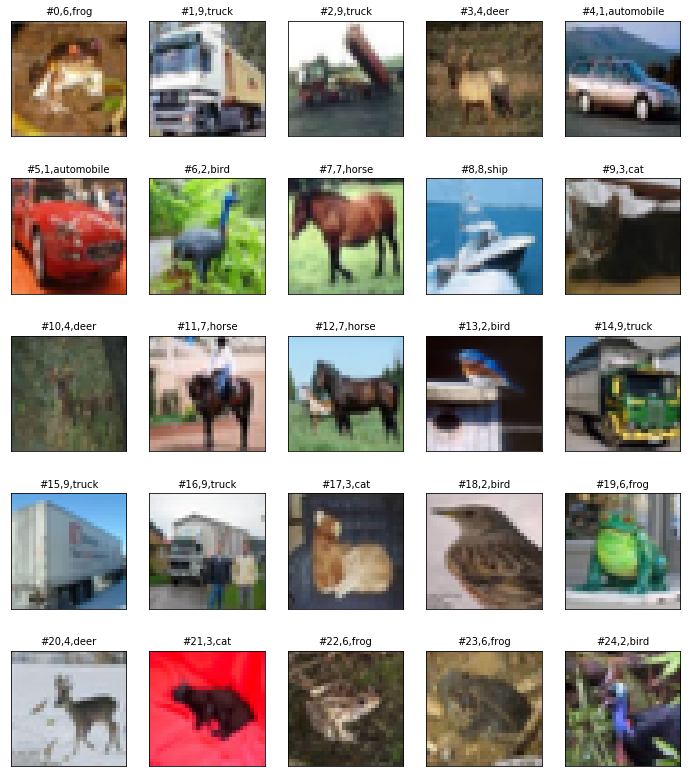

--[TEST ]------------------------------------


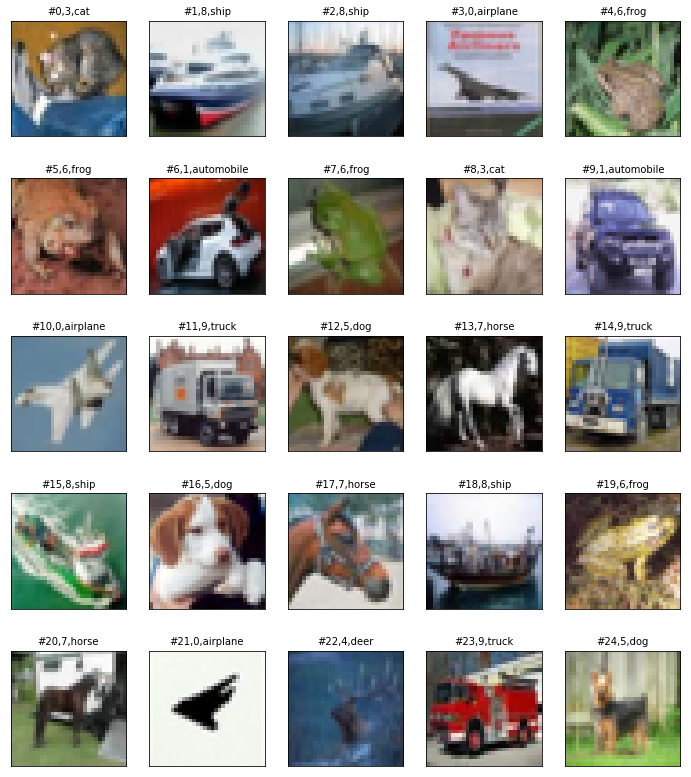

In [11]:
print('--[TRAIN]------------------------------------')
plot_images_labels_prediction(x_train,y_train,[],0, num=50)    
print('--[TEST ]------------------------------------')
plot_images_labels_prediction(x_test,y_test,[],0, num=50)    

--[TRAIN](histogram)------------------------------------


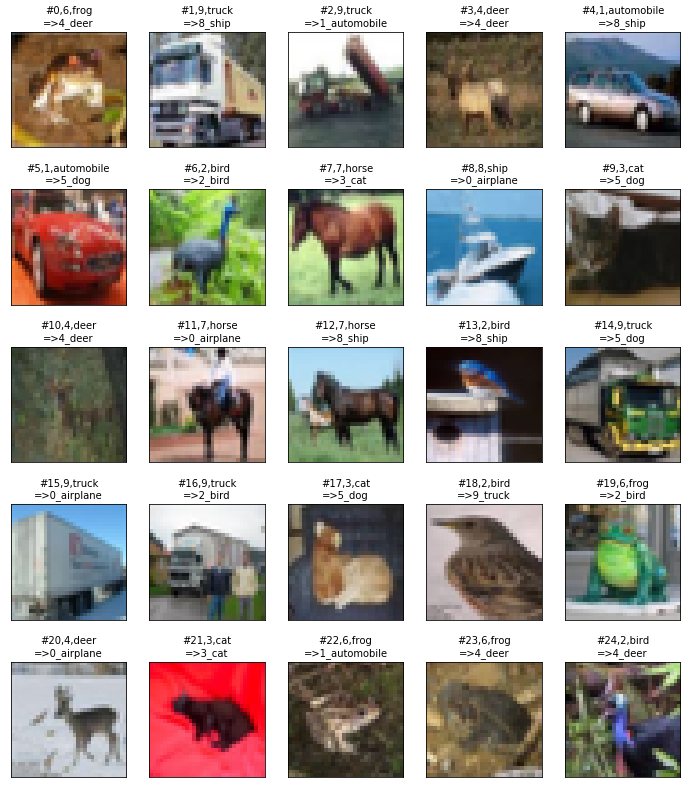

--[TEST ](histogram)------------------------------------


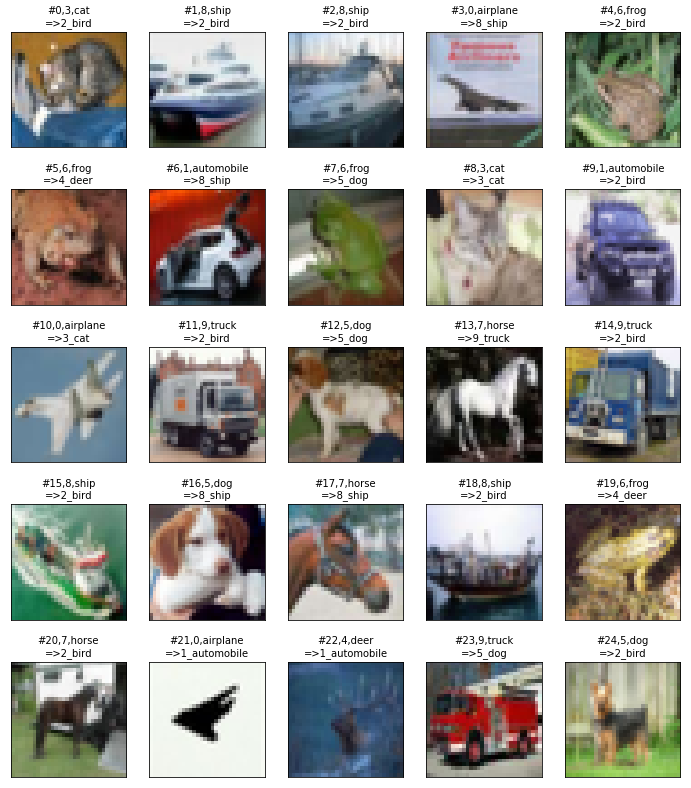

In [12]:
print('--[TRAIN](histogram)------------------------------------')
plot_images_labels_prediction(x_train,y_train,y_hist_train,0, num=50)    
print('--[TEST ](histogram)------------------------------------')
plot_images_labels_prediction(x_test,y_test,y_hist_test,0, num=50)    

--[TRAIN](HOG)------------------------------------


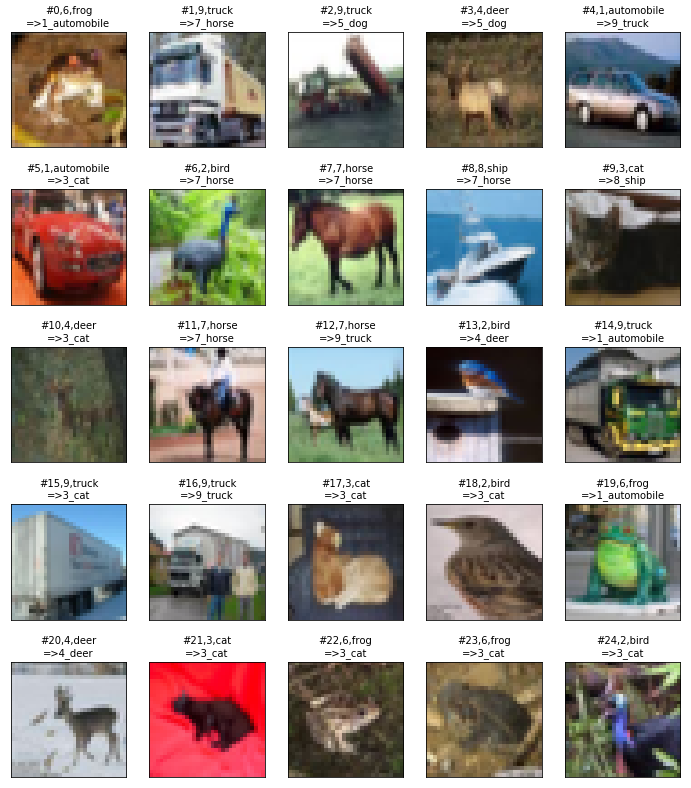

--[TEST ](HOG)------------------------------------


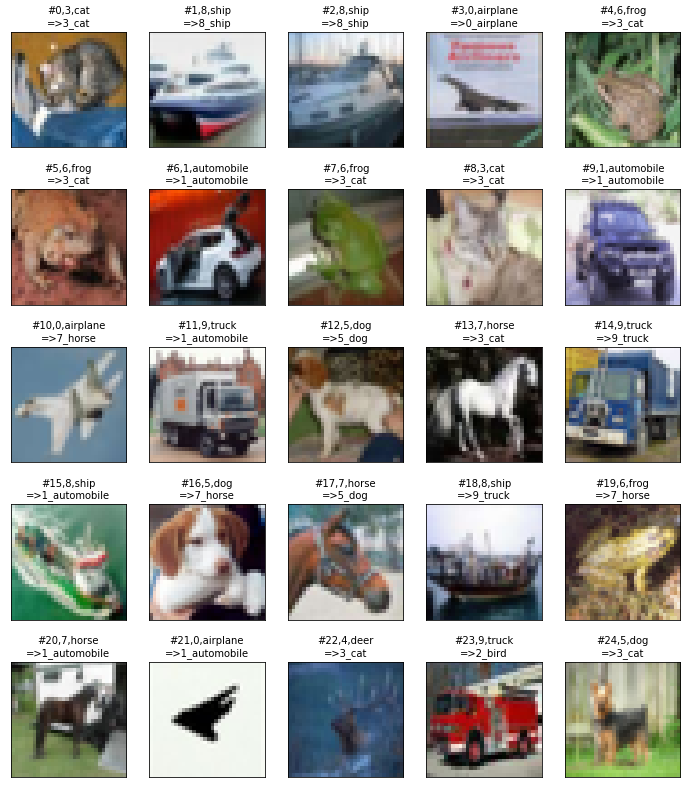

In [13]:
print('--[TRAIN](HOG)------------------------------------')
plot_images_labels_prediction(x_train,y_train,y_hog_train,0, num=50)    
print('--[TEST ](HOG)------------------------------------')
plot_images_labels_prediction(x_test,y_test,y_hog_test,0, num=50)    